In [1]:
### Importing the necessary Python libraries and data needed for the calculations of the time lag

# Python lib import 
import csv
import PyQt5
import warnings
import scipy as sc
from scipy.stats import rankdata as rd
from scipy import optimize as op
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Data import 
data=np.genfromtxt("../Example Data/real_eyemovement_001_1kHz.csv", delimiter=',')
df=pd.DataFrame(data)
data_interpolate=df.interpolate(limit_direction='both')
data1=pd.DataFrame.to_numpy(data_interpolate)
data2=data1.transpose()

t=(data2[0])
x=(data2[2])
y=(data2[1])
r = np.sqrt(x**2+y**2)            # Radial component of x and y data

# Ignoring warnings printed to screen
warnings.filterwarnings("ignore")

In [2]:
### Creating a function to calculate mutual information between a time series x(t) and x(t + tau)

def MI_single(x0, x1, h='sturge', ranking=True):

    # Determining number of points for each input x0 and x1
    Nx0 = len(x0)
    Nx1 = len(x1)
    if Nx0 == Nx1:
        N = Nx0
    else:
        N = min([Nx0, Nx1])
    
    # Performing ranking of data
    if ranking == True:
        x0 = rd(x0, method='ordinal')
        x1 = rd(x1, method='ordinal')

    # Calculating the number of bins to use for the histograms x0, x1 abnd (x0,x1)
    if h == 'sturge':
        Bx0 = np.log2(Nx0) + 1
        Bx1 = np.log2(Nx1) + 1
        B = [Bx0, Bx1]
        B = np.round(np.array(B)).astype(int)     # Ensuring bin is an integer value
    
    # Calculating 1D histograms for x0 and x1
    Hx0 = np.histogram(x1, bins = int(B[0])) [0]
    Hx1 = np.histogram(x1, bins = int(B[1])) [0]

    #  Calculating 2D histogram for (x0, x1)
    Hx0x1 = np.histogram2d(x0, x1, bins = B) [0]

    # Working out the probabilities needed for the AMI factor
    Px0 = Hx0/N
    Px1 = Hx1/N
    Px0x1 = Hx0x1/N

    # Performing the AMI factor calculation 
    I_initial = Px0x1*np.log(Px0x1/(Px1*Px1))
    NaN_check = np.isnan(I_initial)                     # Checking which numbers in data are NaN  np.nansum
    I_initial[NaN_check] = 0                            # Changing NaN entries in series to 0
    I = sum(sum(I_initial))

    # Finishing off function and returning value I
    return(I)

In [3]:
### Creating a function to evaluate mutual information factor as a function of lag

def MI_time_delay(timeseries, plotting=True):

    # Initialising values and constants
    max_delay = 150
    I = []                     # Initialising AMI array
    tau = []                   # Initialising tau array 
    delay = 0

    # Performing the analysis
    while delay < max_delay:
        delay = delay + 1
        x0 = timeseries[:-delay]                # All terms besides last term
        x1 = timeseries[delay:]                 # All terms besides first term
        I.append(MI_single(x0,x1))
        tau.append(delay)

    
    # Calling plot function to plot the graph
    graph = MI_plot(tau, I)

    # Calling function to plot differences
    diff_graph = MI_minima(tau, I)

In [4]:
### Creating function to plot the AMI as a function of time

def MI_plot(tau, I):

    plt.plot(tau, I)
    plt.xlabel('$tau$', fontsize=16)
    plt.ylabel('Mutual information ($nats$)', fontsize=16)
    plt.title('Mutual information plot', fontsize=20, pad=20)
    plt.ylim(0)
    plt.xlim(0)
    plt.show()

In [5]:
### Creating function to calculate difference in AMI factor and printing first local minimum result for tau

def MI_minima(tau, I):

    # Calculating differences
    diffs = np.diff(I)                                                           # Calculating difference between each point in AMI factor
    zero_diffs = np.where(np.logical_and(diffs >= -1e-3, diffs <= 1e-3)) [0]     # Finding points where difference is within a small range around zero i.e. gradient = 0
    tau_array = np.array(tau)                                                    # Converting tau into an array

    # Plotting the difference function and the points where difference is within the small range about zero
    plt.plot(tau[0:149], diffs)
    plt.plot(tau_array[zero_diffs], diffs[zero_diffs], marker="o", linestyle="None")
    plt.xlabel('tau', fontsize=16)
    plt.ylabel('\u0394 Mutual information', fontsize=16)
    plt.axhline(color = 'black')
    plt.title('Change in mutual information', fontsize=20, pad=20)
    plt.show()

    # Printing the value of tau for which the first local minimum is
    print('Tau from calculation:', tau[zero_diffs[0]])



In [6]:
### Creating a noise reduction function using Fourier transform

def MI_fourier(t, x):

    # Performing Fourier transform of input time series data 
    fouriert = sc.fft.rfft(x,len(t))
    xf = sc.fft.rfftfreq(len(t))

    # Removing noise from Fourier transform 
    fouriert_abs = np.abs(fouriert)
    indices = fouriert_abs > 450          # Do a range of values i in range (steps of 10) and plot tau for each, maybe do it in a separate notebook
    fouriert_clean = indices * fouriert
    
    # Performing inverse Fourier Transform to return to the space domain
    fouriert_final = sc.fft.irfft(fouriert_clean)

    return(fouriert_final)

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 8 Text yticklabel objects>)

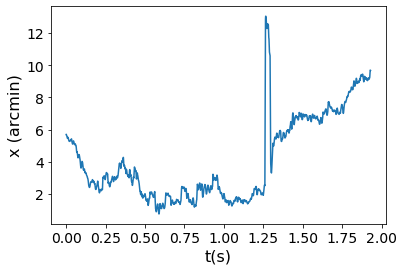

In [29]:
plt.plot(t,x)
plt.xlabel('t(s)', fontsize=16)
plt.ylabel('x (arcmin)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-5.,  0.,  5., 10., 15., 20.]), <a list of 6 Text yticklabel objects>)

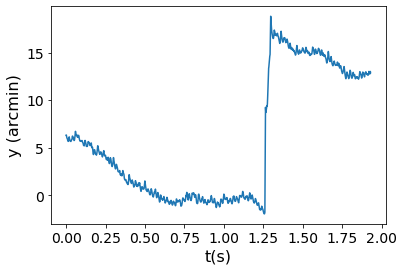

In [28]:
plt.plot(t,y)
plt.xlabel('t(s)', fontsize=16)
plt.ylabel('y (arcmin)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 <a list of 11 Text yticklabel objects>)

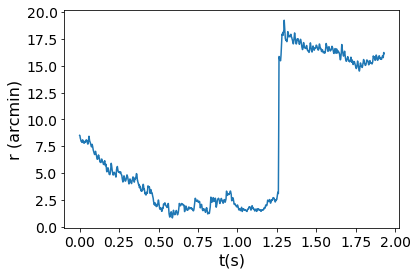

In [27]:
plt.plot(t,r)
plt.xlabel('t(s)', fontsize=16)
plt.ylabel('r (arcmin)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

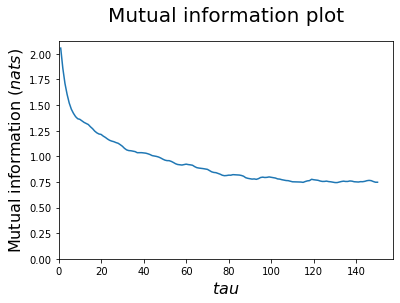

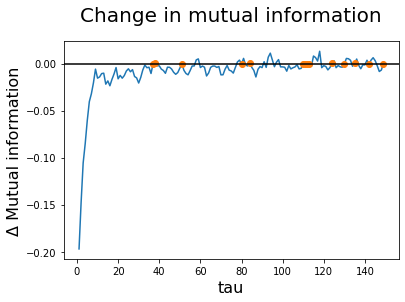

Tau from calculation: 37


In [7]:
### Calculating tau for x dataset

timeseries = x
tau1 = MI_time_delay(timeseries)

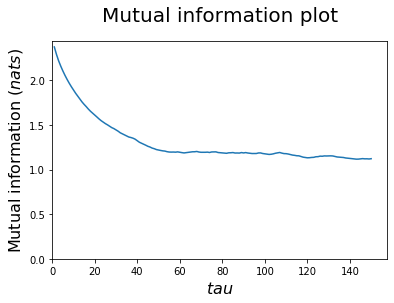

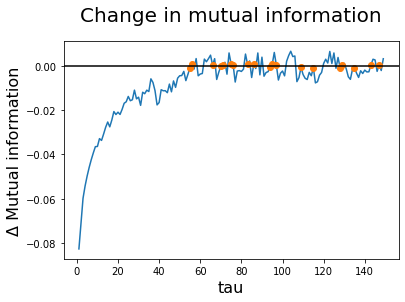

Tau from calculation: 55


In [8]:
### Calculating tau for noise reduced x dataset

# Reducing noise data in the initial time series input
x_smooth = MI_fourier(t,x)

# Performing AMI calculation for reduced noise data
timeseries = x_smooth
tau1_smooth = MI_time_delay(timeseries)

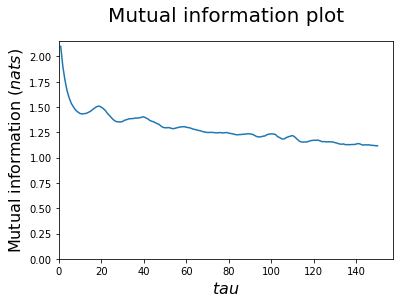

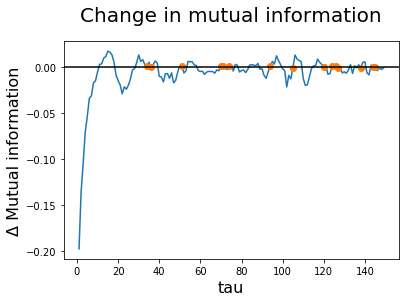

Tau from calculation: 34


In [9]:
### Calculating tau for y dataset 

timeseries = y
tau2 = MI_time_delay(timeseries)

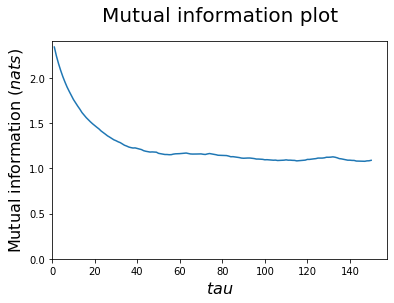

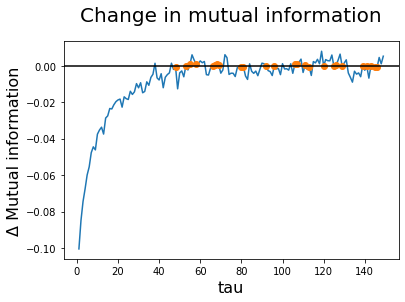

Tau from calculation: 48


In [10]:
### Calculating tau for noise reduced y dataset

# Reducing noise data in the initial time series input
y_smooth = MI_fourier(t,y)

# Performing AMI calculation for reduced noise data
timeseries = y_smooth
tau1_smooth = MI_time_delay(timeseries)

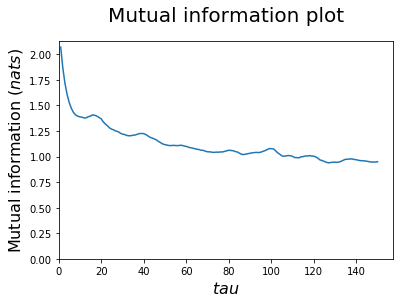

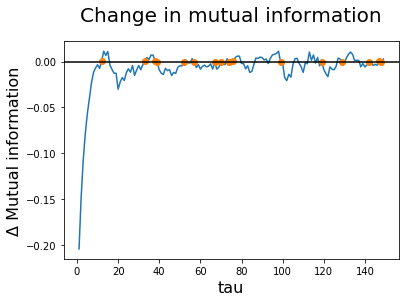

Tau from calculation: 12


In [11]:
### Calculating tau for r dataset

timeseries = r 
tau3 = MI_time_delay(timeseries)

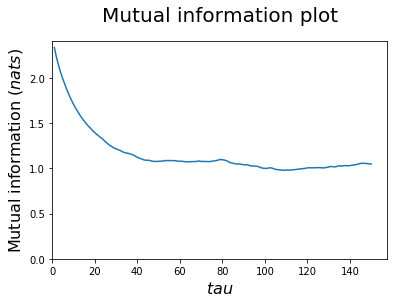

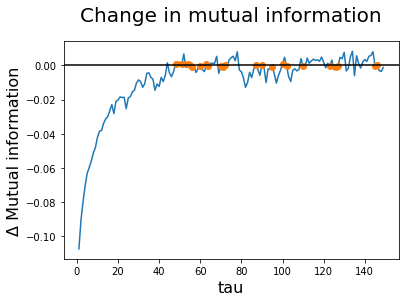

Tau from calculation: 48


In [12]:
### Calculating tau for noise reduced r dataset

# Reducing noise data in the initial time series input
r_smooth = MI_fourier(t,r)

# Performing AMI calculation for reduced noise data
timeseries = r_smooth
tau1_smooth = MI_time_delay(timeseries)